In [1]:
import geopandas
import pandas as pd
import numpy as np
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [8]:
def draw_population(df, weights):
    df2 = df.loc[np.repeat(df.index.values, weights)]
    return df2

# Data

In [9]:
buildings = geopandas.read_file('/home/ai6644/Malmo/Data/Sjöbo/GIS/FastighetskartanBebyggelseVektor_1801_3006/by_get.shp')
buildings = buildings.to_crs("EPSG:4326")
buildings.geometry = buildings.geometry.centroid

/tmp/ipykernel_17691/2813531054.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings.geometry = buildings.geometry.centroid


In [3]:
ruta1000 = geopandas.read_file('/home/ai6644/Malmo/Data/Sjöbo/GIS/B1 ruta 1000 difference with 250.shp')
ruta1000 = ruta1000.to_crs("EPSG:4326")

ruta250 = geopandas.read_file('/home/ai6644/Malmo/Data/Sjöbo/GIS/B1 ruta 250.shp')
ruta250 = ruta250.to_crs("EPSG:4326")

rutas = geopandas.GeoDataFrame(pd.concat([ruta250, ruta1000], axis=0))

rutas['Ruta'] = rutas.Ruta.astype(int)
rutas = rutas.set_index('Ruta')

In [10]:
houses = buildings[buildings.ANDAMAL_1 < 200]
workplaces = geopandas.read_file('/home/ai6644/Malmo/Data/Sjöbo/GIS/workplaces_OSM_SCB_merged.geojson')

In [11]:
resfil_raw = pd.read_csv('/home/ai6644/Malmo/Data/Sjöbo/Travel_survey_Skane_2013/RVU_resfil.csv')
individfil = pd.read_csv('/home/ai6644/Malmo/Data/Sjöbo/Travel_survey_Skane_2013/RVU_individfil.csv')

resfil_raw = resfil_raw[resfil_raw['dagtyp'] == 1]
individfil = individfil[individfil['dagtyp'] == 1]

In [12]:
resfil_raw['rf3a_ärende'] = resfil_raw.rf3a_ärende.replace(88.0, 14.0)
resfil_raw['rf3a_ärende'] = resfil_raw.rf3a_ärende.fillna(14.0)

# Change age grouping

In [13]:
bins = [6, 15, 19, 24, 44, 64, 999]
age_groups = ['Ald7_15','Ald16_19','Ald20_24','Ald25_44','Ald45_64','Ald65_W'] # 'Ald0_6' are excluded
resfil_raw['age_scb'] = pd.cut(resfil_raw.alder_tab, bins=bins, labels=age_groups)
individfil['age_scb'] = pd.cut(individfil.alder_tab, bins=bins, labels=age_groups)

# Find P(trip_chain|age)

In [14]:
freq_age = []
for age in age_groups:
    trip_chains = {}  
    
    # no trips in a day for age bin
    trip_chains[()] = individfil[(individfil['resa.antal'] == 0) & (individfil['age_scb'] == age)].individvikt.sum()
        
    for pid in resfil_raw[resfil_raw.age_scb == age].Id.unique():    
        trips = resfil_raw[resfil_raw.Id == pid]
        chain = tuple(trips['rf3a_ärende'].to_list())
        
        if any([math.isnan(x) for x in chain]):
            chain = tuple(14.0 if math.isnan(x) else x for x in chain)
        chain = tuple(14.0 if x==88.0 else x for x in chain)
        
        if chain in trip_chains.keys():
            trip_chains[chain] += trips['individvikt'].iloc[0]
        else:
            trip_chains[chain] = trips['individvikt'].iloc[0]
    freq_age.append(pd.DataFrame.from_dict(trip_chains, orient='index',columns=[age]))
    
freq_age = freq_age[0].join(freq_age[1], how='outer').join(freq_age[2], how='outer').join(freq_age[3], how='outer').join(freq_age[4], how='outer').join(freq_age[5], how='outer').fillna(0)


In [15]:
freq_age

,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W
(),1157.69444,8793.710176,10549.496811,32804.304065,40670.301050,57157.880167
"(1.0,)",0.00000,468.640294,245.720064,1206.382182,1155.315887,818.161319
"(1.0, 2.0, 1.0)",0.00000,0.000000,0.000000,196.873585,204.457239,30.670769
"(1.0, 2.0, 1.0, 9.0, 1.0)",0.00000,0.000000,0.000000,0.000000,53.009490,0.000000
"(1.0, 2.0, 2.0, 1.0)",0.00000,0.000000,0.000000,0.000000,9.210436,0.000000
...,...,...,...,...,...,...
"(17.0, 7.0, 1.0)",0.00000,0.000000,0.000000,0.000000,0.000000,38.710541
"(17.0, 7.0, 6.0, 1.0)",0.00000,0.000000,0.000000,0.000000,0.000000,14.395073
"(17.0, 8.0, 5.0, 1.0)",0.00000,0.000000,0.000000,0.000000,0.000000,12.346148
"(17.0, 14.0, 6.0, 1.0)",0.00000,0.000000,0.000000,0.000000,54.585932,0.000000


In [16]:
freq_age = freq_age/freq_age.sum()

In [17]:
freq_age

,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W
(),0.127126,0.183978,0.184104,0.140756,0.172202,0.377423
"(1.0,)",0.000000,0.009805,0.004288,0.005176,0.004892,0.005402
"(1.0, 2.0, 1.0)",0.000000,0.000000,0.000000,0.000845,0.000866,0.000203
"(1.0, 2.0, 1.0, 9.0, 1.0)",0.000000,0.000000,0.000000,0.000000,0.000224,0.000000
"(1.0, 2.0, 2.0, 1.0)",0.000000,0.000000,0.000000,0.000000,0.000039,0.000000
...,...,...,...,...,...,...
"(17.0, 7.0, 1.0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000256
"(17.0, 7.0, 6.0, 1.0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000095
"(17.0, 8.0, 5.0, 1.0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000082
"(17.0, 14.0, 6.0, 1.0)",0.000000,0.000000,0.000000,0.000000,0.000231,0.000000


# Sampling (home location|ruta) (trip chain|age)

In [18]:
columns = rutas.columns

In [19]:
persid = 0
persons_df = None
for _,ruta in rutas[(rutas.index > 4177506166250) & ((rutas.index < 4178506166250))].iterrows():
    ruta_repeated = geopandas.GeoDataFrame(np.repeat([ruta.values], len(houses.index), axis=0), columns=columns, geometry='geometry', crs="EPSG:4326")
    ruta_buildings = houses[ruta_repeated.contains(houses.geometry)]
    
    ages = np.repeat(ruta[age_groups].index, ruta[age_groups].values)
    ids = range(persid, persid + ruta.Totalt - ruta.Ald0_6)
    persid += ruta.Totalt
#     name is the 
    ruta_df = np.array([ruta.name]).repeat(len(ids))
    
    # to make DF with person ID and ages
    persons = pd.DataFrame({'id': ids,
                            'age': ages,
                           'ruta': ruta_df}
    )
    
    #sample home location
    persons['home'] = ruta_buildings.sample(n=len(persons.index), replace=True).geometry.values
    
    #sample trip chain | age
    chains = []
    for n,age in zip(ruta[age_groups], age_groups):
        chains.append(freq_age[age].sample(n=n, weights=freq_age[age]))
    persons["trip_chain"] = pd.concat(chains).index
    
    # save to dict
    if persons_df is None:
        persons_df = persons
    else:
        persons_df = pd.concat([persons_df,persons], axis=0, ignore_index=True)       

/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries a

/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/ai6644/miniconda3/envs/gis/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries a

In [20]:
persons_df

,id,age,ruta,home,trip_chain
0,0,Ald7_15,4177506167250,POINT (13.69369 55.64612),"(10.0,)"
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)"
2,2,Ald7_15,4177506167250,POINT (13.69469 55.64541),"(4.0, 1.0)"
3,3,Ald7_15,4177506167250,POINT (13.69469 55.64541),"(4.0, 1.0, 12.0, 1.0)"
4,4,Ald7_15,4177506167250,POINT (13.69581 55.64518),"(4.0, 11.0, 1.0)"
...,...,...,...,...,...
997,1087,Ald25_44,4177506243250,POINT (13.67068 56.32907),"(2.0, 1.0, 6.0, 1.0)"
998,1088,Ald25_44,4177506243250,POINT (13.67018 56.32849),"(2.0, 12.0, 2.0, 2.0, 1.0)"
999,1089,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(6.0, 10.0, 1.0)"
1000,1090,Ald65_W,4177506243250,POINT (13.67018 56.32849),()


# Trip chain to trip pairs

In [21]:
persons_df['chain_length'] = persons_df.trip_chain.apply(len)

In [22]:
persons_df_repeated = persons_df.loc[np.repeat(persons_df.index.values, persons_df.chain_length)]

In [23]:
persons_df_repeated

,id,age,ruta,home,trip_chain,chain_length
0,0,Ald7_15,4177506167250,POINT (13.69369 55.64612),"(10.0,)",1
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4
...,...,...,...,...,...,...
999,1089,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(6.0, 10.0, 1.0)",3
999,1089,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(6.0, 10.0, 1.0)",3
999,1089,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(6.0, 10.0, 1.0)",3
1001,1091,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(2.0, 1.0)",2


In [24]:
trip_pairs = []
for row in persons_df.itertuples():
    chain = row.trip_chain
    for f,s in zip([1.0] + [i for i in chain], chain):
        trip_pairs.append((f,s))

In [25]:
len(trip_pairs)

3430

In [26]:
trip_pairs[-1]

(2.0, 1.0)

In [27]:
persons_df_repeated['trip_pair'] = trip_pairs

In [28]:
persons_df_repeated

,id,age,ruta,home,trip_chain,chain_length,trip_pair
0,0,Ald7_15,4177506167250,POINT (13.69369 55.64612),"(10.0,)",1,"(1.0, 10.0)"
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4,"(1.0, 4.0)"
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4,"(4.0, 1.0)"
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4,"(1.0, 11.0)"
1,1,Ald7_15,4177506167250,POINT (13.69586 55.64459),"(4.0, 1.0, 11.0, 1.0)",4,"(11.0, 1.0)"
...,...,...,...,...,...,...,...
999,1089,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(6.0, 10.0, 1.0)",3,"(1.0, 6.0)"
999,1089,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(6.0, 10.0, 1.0)",3,"(6.0, 10.0)"
999,1089,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(6.0, 10.0, 1.0)",3,"(10.0, 1.0)"
1001,1091,Ald65_W,4177506243250,POINT (13.67068 56.32907),"(2.0, 1.0)",2,"(1.0, 2.0)"


# prepare trip length distributions

In [29]:
upsampled_resfil = draw_population(resfil_raw[['rf7_km', 'age_scb', 'rf3a_ärende']], resfil_raw.individvikt)
upsampled_resfil = upsampled_resfil.dropna(subset=['rf7_km'])

In [30]:
distance = np.linspace(0, 500, 500)

In [31]:
fig, ax = plt.subplots(nrows=6, ncols=17, figsize=(300,70))

prob_age_type = {}

for age,axj in zip(age_groups, range(0,7)):
    loc_resfil = upsampled_resfil[upsampled_resfil['age_scb'] == age]
    
#     fig, ax = plt.subplots(nrows=18, figsize=(7,30))
    
    axi = loc_resfil.rf3a_ärende.unique().astype(int) - 1
    axi.sort()
    loc_resfil.hist(column=['rf7_km'], by=['rf3a_ärende'],bins=range(0,100, 1), density=True, ax=ax[axj][axi])

    for axm, ind in zip(ax[axj].flat, range(1,18)):
        df = loc_resfil[loc_resfil['rf3a_ärende']==ind]
        if len(df.index) == 0:
            continue
        
        kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
        log_dens = kde.score_samples(distance[:, np.newaxis])
        probability = np.exp(log_dens)
        
        prob_age_type[(age, ind)] = probability
        
        axm.plot(distance, probability)
fig.savefig('data/age-type-legth-hist.pdf')

/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dime

/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dime

/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dime

/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/1450870796.py:19: FutureWarning: Support for multi-dime

In [32]:
prob_age_type = pd.DataFrame(prob_age_type)
prob_age_type.head()

Ald7_15                                                                  \
         1             2         4         6         7         8         10   
0  0.053600  2.973439e-07  0.056857  0.059153  0.058266  0.010798  0.040914   
1  0.057632  7.937854e-07  0.060649  0.065813  0.061470  0.015801  0.046075   
2  0.059865  2.035662e-06  0.062513  0.070797  0.062447  0.022213  0.050364   
3  0.060119  5.014953e-06  0.062323  0.073618  0.061099  0.029996  0.053476   
4  0.058423  1.186824e-05  0.060177  0.073973  0.057584  0.038912  0.055200   

                                 ...   Ald65_W                                \
         11        12        13  ...        8         9         10        11   
0  0.039709  0.063491  0.061383  ...  0.040135  0.046152  0.051381  0.050232   
1  0.043149  0.069888  0.065367  ...  0.043605  0.049928  0.055889  0.053966   
2  0.045392  0.074220  0.067127  ...  0.045907  0.052341  0.058759  0.056087   
3  0.046302  0.076023  0.066501  ...  0.046907  0.053257  0.059764  0.056448   
4  0.045888  0.075085  0.063581  ...  0.046603  0.052693  0.058871  0.055088   

                                                               
         12        13        14        15        16        17  
0  0.039590  0.032264  0.045068  0.048977  0.044807  0.005689  
1  0.043007  0.035791  0.048280  0.053868  0.048589  0.006647  
2  0.045241  0.038539  0.050098  0.057461  0.051032  0.007705  
3  0.046147  0.040349  0.050431  0.059525  0.051983  0.008869  
4  0.045718  0.041153  0.049342  0.059970  0.051440  0.010137  

[5 rows x 95 columns]

/tmp/ipykernel_17691/2164830608.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/2164830608.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/2164830608.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/2164830608.py:7: FutureWarning: Support for multi-dimensio

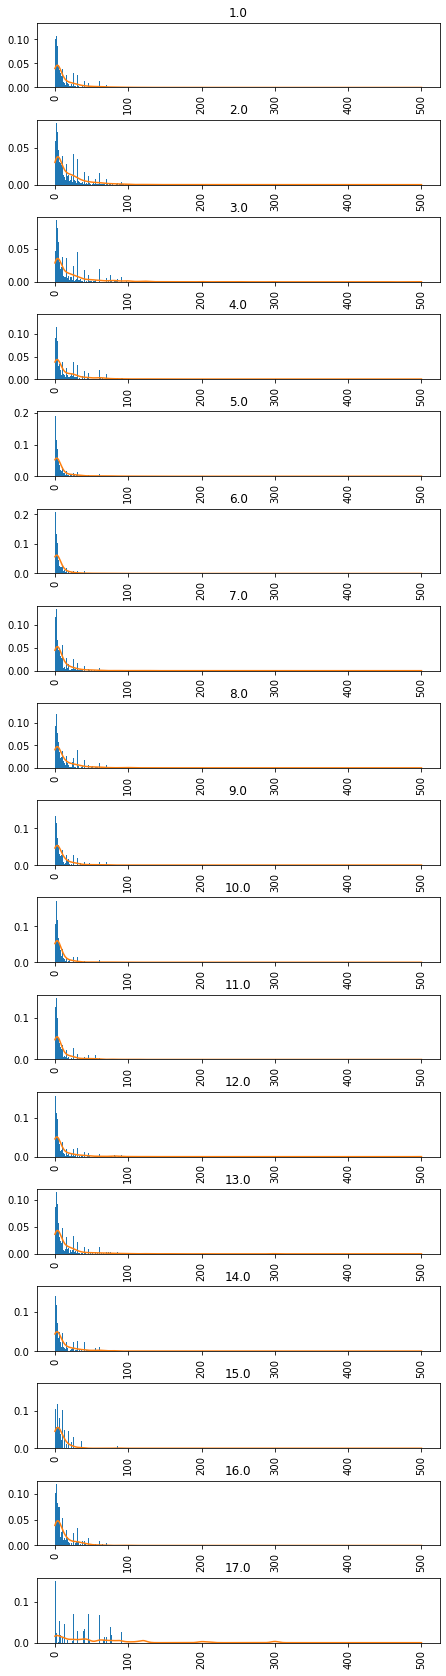

In [33]:
prob_type = {}
fig, ax = plt.subplots(nrows=17, figsize=(7,30))
upsampled_resfil.hist(column=['rf7_km'], by=['rf3a_ärende'],bins=range(0,100, 1), density=True, ax=ax)

for axi, ind in zip(ax.flat, range(1,18)):
    df = upsampled_resfil[['rf7_km', 'rf3a_ärende']][upsampled_resfil['rf3a_ärende']==ind]
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
    log_dens = kde.score_samples(distance[:, np.newaxis])
    probability = np.exp(log_dens)

    prob_type[ind] = probability

    axi.plot(distance, probability)
fig.savefig('data/type-legth-hist.pdf')

In [34]:
prob_type = pd.DataFrame(prob_type)
prob_type.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.039351,0.030045,0.028533,0.037779,0.052186,0.056294,0.044363,0.040338,0.046156,0.051666,0.047165,0.045703,0.036258,0.043297,0.045022,0.038609,0.015750
1,0.042850,0.033249,0.031524,0.040867,0.055636,0.059923,0.048335,0.043857,0.049924,0.056117,0.051043,0.048935,0.039703,0.046663,0.049558,0.042569,0.016679
2,0.045205,0.035692,0.033737,0.042789,0.057361,0.061668,0.051047,0.046187,0.052314,0.058954,0.053451,0.050693,0.042123,0.048700,0.052937,0.045510,0.017223
3,0.046265,0.037222,0.035019,0.043423,0.057255,0.061421,0.052324,0.047184,0.053182,0.059965,0.054220,0.050869,0.043361,0.049287,0.054952,0.047241,0.017398
4,0.046009,0.037778,0.035315,0.042785,0.055404,0.059286,0.052136,0.046843,0.052541,0.059124,0.053353,0.049525,0.043378,0.048456,0.055528,0.047690,0.017254


/tmp/ipykernel_17691/2797451292.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/2797451292.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/2797451292.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
/tmp/ipykernel_17691/2797451292.py:7: FutureWarning: Support for multi-dimensio

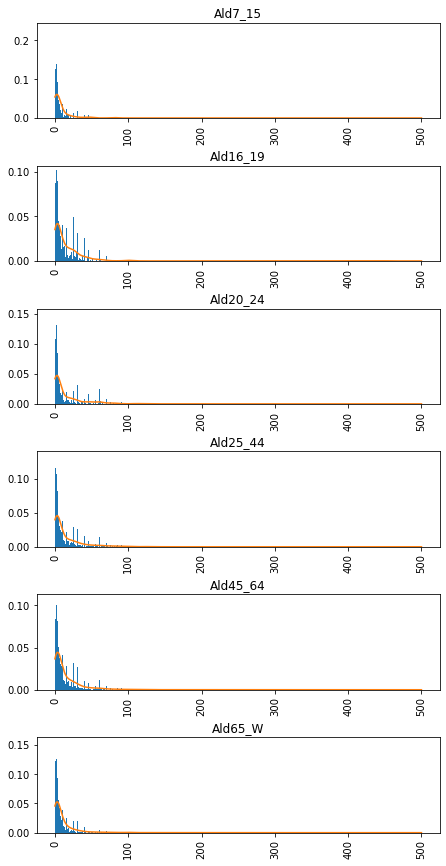

In [35]:
prob_age = {}
fig, ax = plt.subplots(nrows=6, figsize=(7,15))
upsampled_resfil.hist(column=['rf7_km'], by=['age_scb'],bins=range(0,100, 1), density=True, ax=ax)

for axi, age in zip(ax.flat, age_groups):
    df = upsampled_resfil[['rf7_km', 'age_scb']][upsampled_resfil['age_scb']==age]
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
    log_dens = kde.score_samples(distance[:, np.newaxis])
    probability = np.exp(log_dens)

    prob_age[age] = probability

    axi.plot(distance, probability)
fig.savefig('data/age-legth-hist.pdf')

In [36]:
prob_age = pd.DataFrame(prob_age)
prob_age

,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W
0,0.053994,3.514306e-02,4.196672e-02,0.039675,0.036595,0.045532
1,0.058009,3.839605e-02,4.521008e-02,0.042942,0.040175,0.049348
2,0.060234,4.065346e-02,4.709896e-02,0.045012,0.042760,0.051786
3,0.060501,4.177652e-02,4.750119e-02,0.045754,0.044185,0.052688
4,0.058849,4.174496e-02,4.644125e-02,0.045175,0.044401,0.052053
...,...,...,...,...,...,...
495,0.000000,4.980702e-23,2.430211e-10,0.000026,0.000008,0.000015
496,0.000000,7.726914e-24,6.234778e-10,0.000030,0.000009,0.000017
497,0.000000,1.151543e-24,1.536585e-09,0.000033,0.000010,0.000019
498,0.000000,1.648590e-25,3.637899e-09,0.000035,0.000011,0.000020


# distances between rutas

In [2]:
rutas_distance = pd.read_csv("data/rutas_distance_matrix.csv", index_col=0)

In [4]:
rutas_distance.index = rutas.index[range(0,29000)]

In [5]:
rutas_distance.columns = rutas.index[range(0,29000)]

In [6]:
rutas_distance.head()

Ruta,3495006225750,3490006226500,3490006226750,3495006224750,3500006224250,3487506225000,3487506226000,3482506228000,3500006223750,3487506224750,...,4310006167000,4310006272000,4340006231000,4310006254000,4320006277000,4330006294000,4330006169000,4330006278000,4340006196000,4330006177000
Ruta,,,,,,,,,,,,,,,,,,,,,
3495006225750,0.0,2047.0,2115.1,1738.3,2356.8,1436.8,1439.2,3872.9,2950.8,1561.8,...,126298.9,116213.3,100322.2,106136.0,119127.4,136776.0,130045.0,127615.2,132609.1,128565.5
3490006226500,2079.5,0.0,982.8,2326.4,2944.8,2024.8,789.7,2579.7,3538.8,2149.8,...,126886.9,116801.3,100910.2,106724.0,119715.4,137364.0,130633.0,128203.2,133197.1,129153.5
3490006226750,2147.6,982.8,0.0,2394.4,3012.9,2092.9,857.8,1961.8,3606.9,2217.9,...,126955.0,116869.4,100978.2,106792.1,119783.4,137432.1,130701.0,128271.3,133265.1,129221.5
3495006224750,1710.2,2326.9,2395.0,0.0,895.9,837.4,1719.1,5605.9,1489.9,907.4,...,124838.0,114752.4,98861.2,104675.1,117666.5,135315.1,128584.1,126154.3,131148.2,127104.6
3500006224250,2328.7,2945.4,3013.5,895.9,0.0,1811.4,2337.5,6028.4,695.6,1765.9,...,124043.7,113958.1,98066.9,103880.8,116872.1,134520.8,127789.7,125360.0,130353.8,126310.2


In [7]:
rutas_distance.to_feather('data/rutas_distance_matrix.feather')

ImportError: Missing optional dependency 'pyarrow'.  Use pip or conda to install pyarrow.

In [160]:
rutas_with_buildings = pd.read_csv('data/rutas_with_buildings.csv')
rutas_with_buildings = rutas_with_buildings.set_index('Ruta')
rutas_with_buildings

,Rutstorl,Ald0_6,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W,Totalt,geometry,houses_in_ruta,workplaces_in_ruta
Ruta,,,,,,,,,,,,
3495006225750,250,4,14,7,0,13,19,9,66,POLYGON ((12.57704370735638 56.152983413016315...,"Int64Index([ 44906, 45233, 45715, 45863, 4...","Int64Index([], dtype='int64')"
3490006226500,250,13,29,16,4,29,50,33,174,POLYGON ((12.568576712448548 56.15955795078417...,"Int64Index([ 44713, 44770, 44850, 44903, 4...","Int64Index([], dtype='int64')"
3490006226750,250,0,0,0,0,5,5,10,20,POLYGON ((12.568434872350581 56.16180209649136...,"Int64Index([ 45385, 45761, 46160, 47033, 4...","Int64Index([], dtype='int64')"
3495006224750,250,3,10,7,3,11,36,30,100,POLYGON ((12.577608751368668 56.14400675376524...,"Int64Index([ 262, 44609, 44711, 44918, 4...","Int64Index([262], dtype='int64')"
3500006224250,250,0,3,0,0,4,3,5,15,POLYGON ((12.585930017630371 56.13967581082828...,"Int64Index([46345, 47484, 47589, 48152, 49000,...","Int64Index([], dtype='int64')"
...,...,...,...,...,...,...,...,...,...,...,...,...
4310006169000,1000,4,4,0,3,13,6,10,40,POLYGON ((13.903190649150334 55.66193256316584...,"Int64Index([ 58567, 58859, 58990, 59155, 5...","Int64Index([], dtype='int64')"
4310006196000,1000,0,3,0,0,3,4,0,10,POLYGON ((13.896355040047682 55.90448994847212...,"Int64Index([80185, 81919, 251340], dtype='int64')","Int64Index([], dtype='int64')"
4320006144000,1000,0,0,0,0,0,3,6,9,POLYGON ((13.925229802097993 55.43747314173065...,"Int64Index([99462, 243722, 261126, 261127, 261...","Int64Index([], dtype='int64')"


In [166]:
def parse_index(x):
    print(x)
    return literal_eval(x.replace('\n','')[11:-16])

In [167]:
rutas_with_buildings['houses_in_ruta'] = rutas_with_buildings.houses_in_ruta.apply(parse_index)

Int64Index([ 44906,  45233,  45715,  45863,  46007,  48302,  49121,  49973,
            235708, 236315, 236432, 236500, 276858, 276881, 277152, 277158,
            294627, 294629, 294654, 294662, 294678, 294679, 294694, 329115,
            329117],
           dtype='int64')
Int64Index([ 44713,  44770,  44850,  44903,  44913,  44956,  45043,  45092,
             45371,  45538,  45688,  45975,  46050,  46178,  46181,  46263,
             46290,  46479,  46495,  46588,  46630,  46791,  46793,  46822,
             46846,  46886,  46935,  47002,  47239,  47607,  47610,  47650,
             48341,  48424,  48671,  48745,  48906,  48982,  49544,  49959,
             50113,  50336,  50402, 216964, 223498, 227137, 227170, 234684,
            236373, 236671, 236674, 239885, 239922, 241388, 277007, 277086,
            277265, 277268, 284780, 304533, 304556, 304638, 304648, 304793],
           dtype='int64')
Int64Index([ 45385,  45761,  46160,  47033,  47443,  47722,  47727,  48115,
             4

SyntaxError: invalid syntax (<unknown>, line 1)

# Assign buildings

In [85]:
for trip in persons_df_repeated.itertuples():
    
    if trip.trip_pair in [(1,2)]: # house - work
        trip_distance = prob_age_type[(trip.age, trip.trip_pair[1])].sample(1, weights=prob_age_type[(trip.age, trip.trip_pair[1])].values).index[0]
        trip_distance = trip_distance*1000
    else:
        continue
    
#     if it is home-work
    if trip.ruta not in rutas_distance:
        continue
    distance_row = rutas_distance[trip.ruta]
    dist_interval = 1000 + trip_distance*0.1
    rutas_within_trip_distance_ind = distance_row[(distance_row.values < trip_distance + dist_interval) & (distance_row.values > trip_distance - dist_interval)].index
    rutas_within_trip_distance = rutas_with_buildings.loc[rutas_within_trip_distance_ind]
    
    # need a table ruta-buildings
    workspaces_ind = rutas_within_trip_distance.workplaces_in_ruta.values.flatten()
    workplace = workplaces[workspaces_ind].sample()
    
    break
    
# if it is  ?-> home
    

KeyError: "None of [Index(['Int64Index([17097], dtype='int64')',\n       'Int64Index([14406, 15177, 16454], dtype='int64')',\n       'Int64Index([15298, 16004, 16204, 17361, 17551, 17625, 18045, 20667, 21043,\\n            22219, 22799, 22860, 23196, 23216, 23287, 23890, 24000],\\n           dtype='int64')',\n       'Int64Index([15659, 16237, 16347, 17961, 18368, 19697, 20606, 22729, 23232,\\n            23897],\\n           dtype='int64')',\n       'Int64Index([14479, 15637, 15765, 16341, 17268, 17622, 17971, 18856, 19331,\\n            19776, 20142, 21383, 23081, 23234, 23467],\\n           dtype='int64')',\n       'Int64Index([24051], dtype='int64')',\n       'Int64Index([14646, 14897, 15091, 15348, 16131, 16166, 16167, 17236, 17329,\\n            17520, 17587, 17994, 18489, 19324, 20386, 20387, 21004, 21183,\\n            21806, 21995, 22371, 22495, 22723, 22919, 23774],\\n           dtype='int64')',\n       'Int64Index([14417, 15353, 15823, 15847, 15957, 16107, 17997, 19267, 19491,\\n            19528, 19705, 19818, 20328, 20491, 21797, 23757],\\n           dtype='int64')',\n       'Int64Index([14615, 14918, 15075, 15144, 15212, 15213, 15235, 15464, 15922,\\n            16037, 16051, 17117, 18242, 19443, 19943, 20007, 20196, 20287,\\n            20686, 20967, 20994, 21407, 21846, 21960, 22725, 22998, 23138,\\n            23167, 23759, 23818],\\n           dtype='int64')',\n       'Int64Index([14605, 14642, 15720, 16146, 16378, 16432, 17163, 17462, 17927,\\n            19441, 19975, 20363, 22354, 22355],\\n           dtype='int64')',\n       ...\n       'Int64Index([33384, 33477, 33715, 33865, 33935, 33975, 34536, 34557, 34671,\\n            34699, 34762, 34807, 35040, 35273, 35964, 36115, 36146, 36166,\\n            36209, 36329],\\n           dtype='int64')',\n       'Int64Index([], dtype='int64')', 'Int64Index([], dtype='int64')',\n       'Int64Index([], dtype='int64')',\n       'Int64Index([33356, 33838, 33866, 34193, 34604, 35123, 35304, 35373, 35415,\\n            35626, 35763, 35807],\\n           dtype='int64')',\n       'Int64Index([], dtype='int64')',\n       'Int64Index([34112, 34120, 34842, 34843], dtype='int64')',\n       'Int64Index([], dtype='int64')',\n       'Int64Index([33690, 35274], dtype='int64')',\n       'Int64Index([], dtype='int64')'],\n      dtype='object', length=479)] are in the [columns]"

In [86]:
trip_distance

18000

In [87]:
trip_distance + dist_interval

20800.0

In [89]:
trip_distance - dist_interval

15200.0

In [90]:
rutas_within_trip_distance_ind

Int64Index([4045006166250, 4045006166000, 4045006166500, 4057506165000,
            4042506166250, 4040006166250, 4057506164750, 4055006164500,
            4045006167250, 4057506164250,
            ...
            4330006163000, 4320006170000, 4310006163000, 4320006167000,
            4340006163000, 4320006162000, 4320006158000, 4320006168000,
            4310006158000, 4310006167000],
           dtype='int64', name='Ruta', length=458)

In [98]:
workspaces_ind[0]

"Int64Index([17097], dtype='int64')"

In [108]:
rutas_within_trip_distance.houses_in_ruta.loc[4045006166250]

"Int64Index([17097, 240478, 240484, 240485, 240486, 240487, 242410], dtype='int64')"

In [106]:
from ast import literal_eval

In [110]:
pd.Int64Index([17097, 240478, 240484, 240485, 240486, 240487, 242410], dtype='int64')

/tmp/ipykernel_17691/3789712832.py:1: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index([17097, 240478, 240484, 240485, 240486, 240487, 242410], dtype='int64')


Int64Index([17097, 240478, 240484, 240485, 240486, 240487, 242410], dtype='int64')

In [151]:
rutas_within_trip_distance.sample(10).houses_in_ruta.apply(lambda x: test(x))

Int64Index([ 14383,  14517,  14988,  15052,  15150,  15194,  15210,  15845,
             16374,  16901,  17096,  18003,  18054,  18492,  18933,  18951,
             18999,  19574,  19727,  20209,  20905,  20977,  21541,  21994,
             22369,  22661,  22876,  23448,  23462,  23816,  23976, 148299,
            219328, 220272, 242456],
           dtype='int64')
Int64Index([58967, 59189, 59815, 61658, 62866, 62935, 144199, 152263, 152265,
            257107],
           dtype='int64')
Int64Index([59210, 59779, 245255], dtype='int64')
Int64Index([16482, 23689], dtype='int64')
Int64Index([152834, 152871, 249951], dtype='int64')
Int64Index([110663, 144472, 144473], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([152892, 249950, 257640], dtype='int64')
Int64Index([ 59221,  59635,  61462,  62758, 149486, 152789, 152858, 156300,
            249041, 252799, 252884],
           dtype='int64')
Int64Index([58487, 61536, 245257, 257098], dtype='int64')


Ruta
4060006164750    ([14383, 14517, 14988, 15052, 15150, 15194, 15...
4260006176000    ([58967, 59189, 59815, 61658, 62866, 62935, 14...
4090006158000                               [59210, 59779, 245255]
4062506165250                                       [16482, 23689]
4110006159000                             [152834, 152871, 249951]
4077506176000                             [110663, 144472, 144473]
4075006175000                                                   []
4150006155000                             [152892, 249950, 257640]
4230006175000    ([59221, 59635, 61462, 62758, 149486, 152789, ...
4097506158250                       [58487, 61536, 245257, 257098]
Name: houses_in_ruta, dtype: object

In [141]:
x = "Int64Index([ 59649,  59796,  60728,  61546,  63114, 152193, 249053, 249054,
            252926, 257391, 277450],
           dtype='int64')"
literal_eval(x[11:-16])

SyntaxError: EOL while scanning string literal (3279491632.py, line 1)

In [140]:
x

"Int64Index([ 59649,  59796,  60728,  61546,  63114, 152193, 249053, 249054,            252926, 257391, 277450],           dtype='int64')"